In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, IterableDataset
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:

# --- File Paths ---
TRAIN_FILE_PATH = '/kaggle/input/sdm-asg1/Amazon-670K_tfidf_train_ver1.svm'
TEST_FILE_PATH = '/kaggle/input/sdm-asg1/Amazon-670K_tfidf_test_ver1.svm'

# --- Model and Data Dimensions ---
INPUT_DIM = 135909
OUTPUT_DIM = 670091      
EMBEDDING_DIM = 64     

# --- Training Hyperparameters ---
BATCH_SIZE = 256
EPOCHS = 4
LEARNING_RATES = [0.1, 0.01, 0.001]

In [ ]:
class LibSVMDataset(IterableDataset):
    def __init__(self, file_path, num_features, num_classes, limit=None): # Added 'limit'
        super(LibSVMDataset, self).__init__()
        self.file_path = file_path
        self.num_features = num_features
        self.num_classes = num_classes
        self.limit = limit  # Store the sample limit

    def __iter__(self):
        with open(self.file_path, 'r') as f:
            for i, line in enumerate(f):
                # Stop if the sample limit is reached
                if self.limit and i >= self.limit:
                    break
                
                parts = line.strip().split()
                labels_str = parts[0]
                features_str = parts[1:]

                # Use original labels directly to create the target tensor
                original_labels = [int(l) for l in labels_str.split(',')]
                target = torch.zeros(self.num_classes, dtype=torch.float32)
                if original_labels:
                    target.scatter_(0, torch.tensor(original_labels), 1)

                # Feature handling for sparse tensors
                indices, values = [], []
                for item in features_str:
                    index, value = item.split(':')
                    indices.append(int(index))
                    values.append(float(value))

                features = torch.sparse_coo_tensor(
                    [indices], values, (self.num_features,), dtype=torch.float32
                )
                yield features, target


def sparse_batch_collate(batch):
    features_list, targets_list = zip(*batch)
    return torch.stack(features_list, 0), torch.stack(targets_list, 0)

In [ ]:
class LowRankClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim):
        super(LowRankClassifier, self).__init__()
        # Projects input features to a low-dimensional embedding space
        self.embedding_layer = nn.Linear(input_dim, embedding_dim)
        # Projects the embedding to the full output label space
        self.output_layer = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x_dense = x.to_dense()
        embedding = self.embedding_layer(x_dense)
        outputs = self.output_layer(embedding)
        return outputs


In [ ]:
def train_and_evaluate(optimizer_name, learning_rate):
    print("-" * 60)
    print(f"Starting Training: Optimizer={optimizer_name}, LR={learning_rate}")
    print("-" * 60)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = LowRankClassifier(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM).to(device)
    criterion = nn.BCEWithLogitsLoss()

    # Select the optimizer
    if optimizer_name == "SGD_NO_Momentum":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD_Momentum":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == "Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

    # Initialize DataLoaders 
    train_dataset = LibSVMDataset(TRAIN_FILE_PATH, INPUT_DIM, OUTPUT_DIM)
    test_dataset = LibSVMDataset(TEST_FILE_PATH, INPUT_DIM, OUTPUT_DIM)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=sparse_batch_collate)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=sparse_batch_collate)

    train_losses = []
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training")
        for i, (features, targets) in enumerate(train_iterator):
            features, targets = features.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        epoch_loss = running_loss / (i + 1)
        train_losses.append(epoch_loss)
        print(f"\nEpoch {epoch+1} Summary: Training Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    
    print("\nStarting evaluation...")
    model.eval()
    
    # Initialize accumulators for metrics
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    num_batches = 0

    test_iterator = tqdm(test_loader, desc="Evaluating")
    
    with torch.no_grad():
        for features, targets in test_iterator:
            features = features.to(device)
            targets_np = targets.numpy().astype(int)

            outputs = model(features)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()

            total_precision += precision_score(targets_np, preds, average='samples', zero_division=0)
            total_recall += recall_score(targets_np, preds, average='samples', zero_division=0)
            total_f1 += f1_score(targets_np, preds, average='samples', zero_division=0)
            
            num_batches += 1

    # Calculate the average metrics across all batches
    avg_precision = total_precision / num_batches if num_batches > 0 else 0
    avg_recall = total_recall / num_batches if num_batches > 0 else 0
    avg_f1 = total_f1 / num_batches if num_batches > 0 else 0
    
    metrics = {'Precision': avg_precision, 'Recall': avg_recall, 'F1-score': avg_f1}
    print(f"\nMetrics: Precision={avg_precision:.8f}, Recall={avg_recall:.8f}, F1-score={avg_f1:.8f}")
    print("-" * 60 + "\n")
    
    return train_losses, metrics

In [ ]:
loss_history = {}
metrics_history = {}

------------------------------------------------------------
Starting Training: Optimizer=SGD_NO_Momentum, LR=0.1
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:03,  1.59it/s]



Epoch 1 Summary: Training Loss: 0.6939, Time: 123.41s


Epoch 2/4 Training: 196it [02:02,  1.60it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 122.28s


Epoch 3/4 Training: 196it [02:02,  1.60it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 122.20s


Epoch 4/4 Training: 196it [02:02,  1.60it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 122.16s

Starting evaluation...


Evaluating: 6it [14:05, 140.94s/it]



Metrics: Precision=0.00000781, Recall=0.50025506, F1-score=0.00001561
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=SGD_NO_Momentum, LR=0.01
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:03,  1.58it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 123.83s


Epoch 2/4 Training: 196it [02:04,  1.58it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 124.05s


Epoch 3/4 Training: 196it [02:03,  1.59it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 123.50s


Epoch 4/4 Training: 196it [02:03,  1.58it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 123.97s

Starting evaluation...


Evaluating: 6it [14:05, 140.99s/it]



Metrics: Precision=0.00000766, Recall=0.50017192, F1-score=0.00001532
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=SGD_NO_Momentum, LR=0.001
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:03,  1.59it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 123.35s


Epoch 2/4 Training: 196it [02:03,  1.59it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 123.40s


Epoch 3/4 Training: 196it [02:03,  1.58it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 123.87s


Epoch 4/4 Training: 196it [02:04,  1.58it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 124.08s

Starting evaluation...


Evaluating: 6it [14:05, 140.94s/it]



Metrics: Precision=0.00000764, Recall=0.49778051, F1-score=0.00001527
------------------------------------------------------------



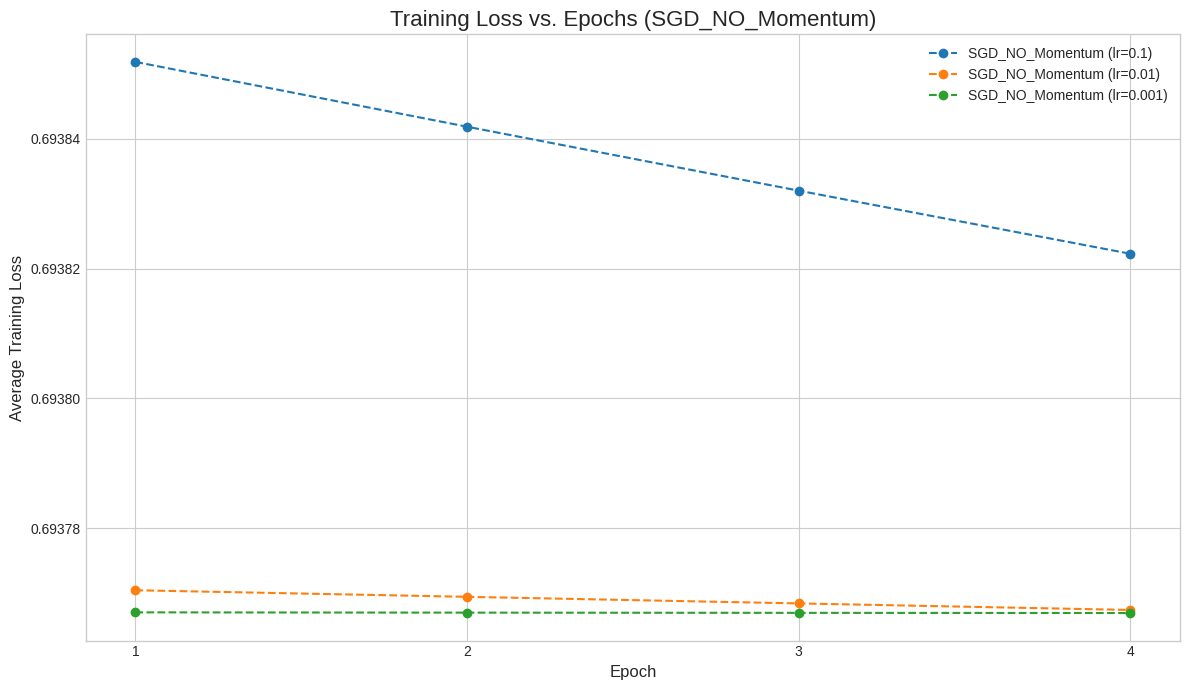

In [7]:
optimizer_type = "SGD_NO_Momentum"
for lr in LEARNING_RATES:
    key = f"{optimizer_type} (lr={lr})"
    losses, metrics = train_and_evaluate(
        optimizer_name=optimizer_type,
        learning_rate=lr
    )
    loss_history[key] = losses
    metrics_history[key] = metrics

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
for label, losses in loss_history.items():
    if optimizer_type in label:
        plt.plot(range(1, EPOCHS + 1), losses, marker='o', linestyle='--', label=label)

plt.title(f'Training Loss vs. Epochs ({optimizer_type})', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss', fontsize=12)
plt.xticks(range(1, EPOCHS + 1))
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

------------------------------------------------------------
Starting Training: Optimizer=SGD_Momentum, LR=0.1
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:04,  1.57it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 124.72s


Epoch 2/4 Training: 196it [02:04,  1.58it/s]



Epoch 2 Summary: Training Loss: 0.6937, Time: 124.20s


Epoch 3/4 Training: 196it [02:04,  1.58it/s]



Epoch 3 Summary: Training Loss: 0.6936, Time: 124.33s


Epoch 4/4 Training: 196it [02:04,  1.58it/s]



Epoch 4 Summary: Training Loss: 0.6935, Time: 124.17s

Starting evaluation...


Evaluating: 6it [14:12, 142.14s/it]



Metrics: Precision=0.00000781, Recall=0.49995291, F1-score=0.00001562
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=SGD_Momentum, LR=0.01
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:05,  1.56it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 125.64s


Epoch 2/4 Training: 196it [02:04,  1.57it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 124.89s


Epoch 3/4 Training: 196it [02:05,  1.57it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 125.23s


Epoch 4/4 Training: 196it [02:04,  1.57it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 125.02s

Starting evaluation...


Evaluating: 6it [14:08, 141.40s/it]



Metrics: Precision=0.00000762, Recall=0.49418702, F1-score=0.00001525
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=SGD_Momentum, LR=0.001
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:05,  1.56it/s]



Epoch 1 Summary: Training Loss: 0.6937, Time: 125.79s


Epoch 2/4 Training: 196it [02:05,  1.57it/s]



Epoch 2 Summary: Training Loss: 0.6937, Time: 125.20s


Epoch 3/4 Training: 196it [02:04,  1.57it/s]



Epoch 3 Summary: Training Loss: 0.6937, Time: 124.94s


Epoch 4/4 Training: 196it [02:05,  1.57it/s]



Epoch 4 Summary: Training Loss: 0.6937, Time: 125.22s

Starting evaluation...


Evaluating: 6it [14:15, 142.59s/it]



Metrics: Precision=0.00000771, Recall=0.50175139, F1-score=0.00001543
------------------------------------------------------------



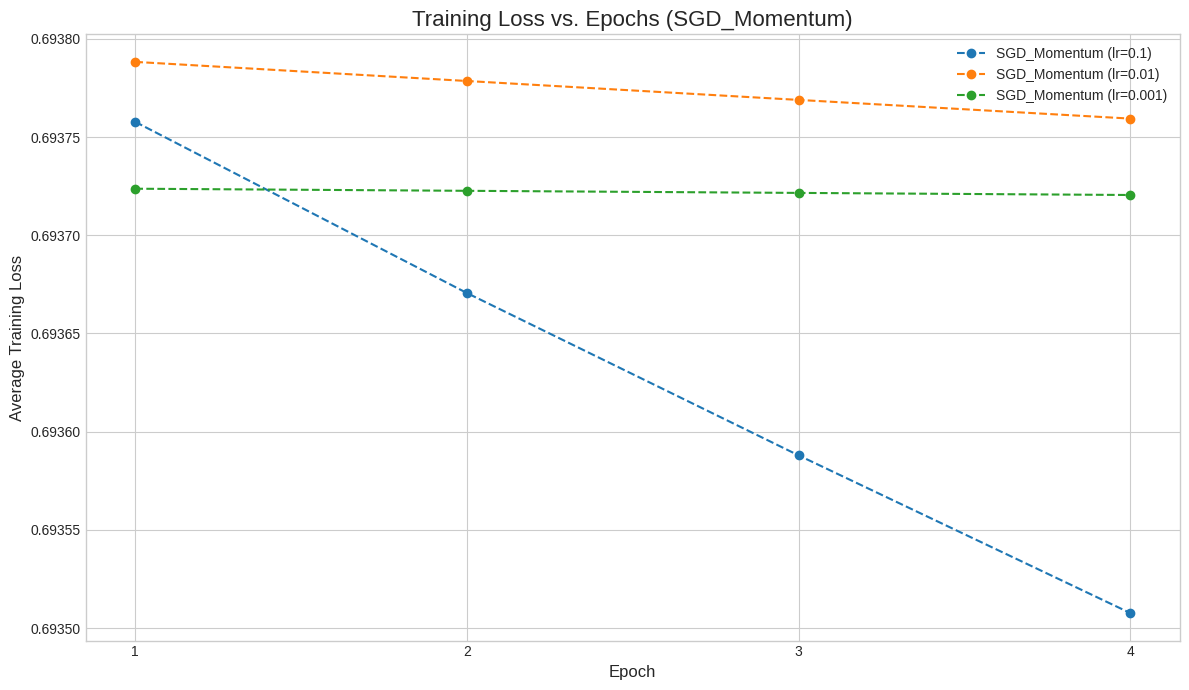

In [8]:
optimizer_type = "SGD_Momentum"
for lr in LEARNING_RATES:
    key = f"{optimizer_type} (lr={lr})"
    losses, metrics = train_and_evaluate(
        optimizer_name=optimizer_type,
        learning_rate=lr
    )
    loss_history[key] = losses
    metrics_history[key] = metrics

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
for label, losses in loss_history.items():
    if optimizer_type in label:
        plt.plot(range(1, EPOCHS + 1), losses, marker='o', linestyle='--', label=label)

plt.title(f'Training Loss vs. Epochs ({optimizer_type})', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss', fontsize=12)
plt.xticks(range(1, EPOCHS + 1))
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

------------------------------------------------------------
Starting Training: Optimizer=Adadelta, LR=0.1
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:06,  1.55it/s]



Epoch 1 Summary: Training Loss: 0.6939, Time: 126.57s


Epoch 2/4 Training: 196it [02:06,  1.55it/s]



Epoch 2 Summary: Training Loss: 0.6939, Time: 126.43s


Epoch 3/4 Training: 196it [02:06,  1.55it/s]



Epoch 3 Summary: Training Loss: 0.6939, Time: 126.73s


Epoch 4/4 Training: 196it [02:06,  1.55it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 126.74s

Starting evaluation...


Evaluating: 6it [14:14, 142.44s/it]



Metrics: Precision=0.00000799, Recall=0.52381389, F1-score=0.00001599
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=Adadelta, LR=0.01
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:06,  1.54it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 126.95s


Epoch 2/4 Training: 196it [02:06,  1.55it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 126.30s


Epoch 3/4 Training: 196it [02:06,  1.55it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 126.19s


Epoch 4/4 Training: 196it [02:06,  1.54it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 126.93s

Starting evaluation...


Evaluating: 6it [14:12, 142.08s/it]



Metrics: Precision=0.00000775, Recall=0.50376942, F1-score=0.00001550
------------------------------------------------------------

------------------------------------------------------------
Starting Training: Optimizer=Adadelta, LR=0.001
------------------------------------------------------------
Using device: cuda


Epoch 1/4 Training: 196it [02:06,  1.55it/s]



Epoch 1 Summary: Training Loss: 0.6938, Time: 126.80s


Epoch 2/4 Training: 196it [02:06,  1.54it/s]



Epoch 2 Summary: Training Loss: 0.6938, Time: 127.02s


Epoch 3/4 Training: 196it [02:06,  1.55it/s]



Epoch 3 Summary: Training Loss: 0.6938, Time: 126.38s


Epoch 4/4 Training: 196it [02:06,  1.55it/s]



Epoch 4 Summary: Training Loss: 0.6938, Time: 126.22s

Starting evaluation...


Evaluating: 6it [14:10, 141.81s/it]



Metrics: Precision=0.00000730, Recall=0.47412301, F1-score=0.00001461
------------------------------------------------------------



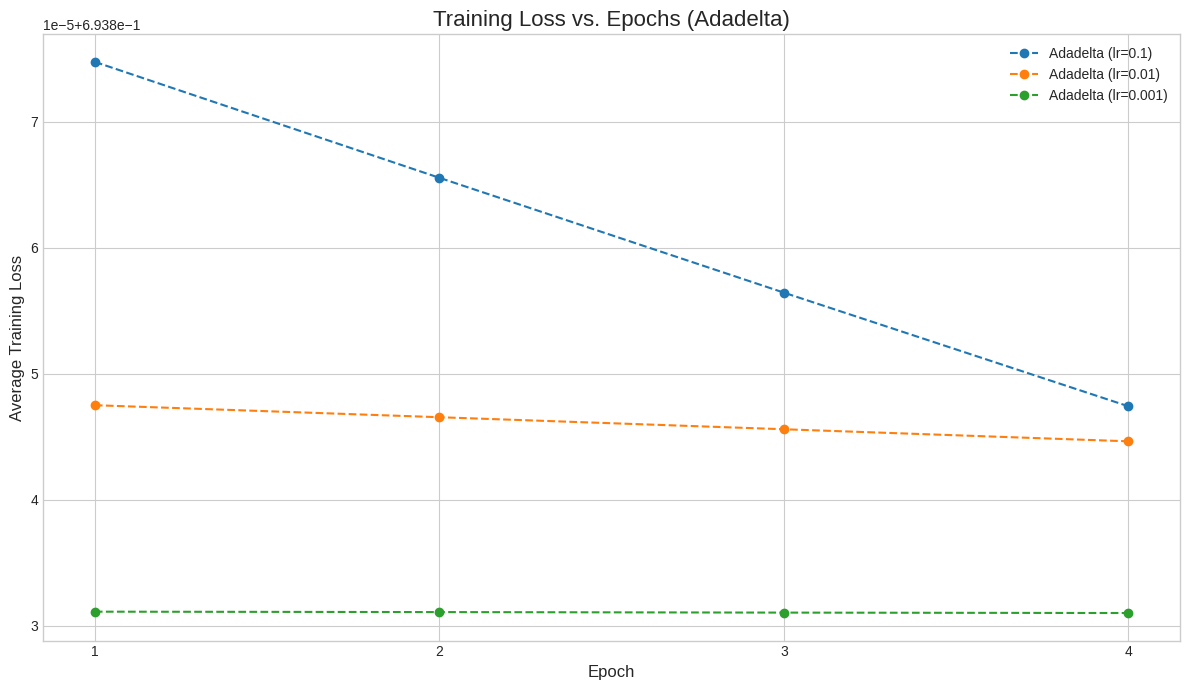

In [9]:
optimizer_type = "Adadelta"
for lr in LEARNING_RATES:
    key = f"{optimizer_type} (lr={lr})"
    losses, metrics = train_and_evaluate(
        optimizer_name=optimizer_type,
        learning_rate=lr
    )
    loss_history[key] = losses
    metrics_history[key] = metrics

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
for label, losses in loss_history.items():
    if optimizer_type in label:
        plt.plot(range(1, EPOCHS + 1), losses, marker='o', linestyle='--', label=label)

plt.title(f'Training Loss vs. Epochs ({optimizer_type})', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss', fontsize=12)
plt.xticks(range(1, EPOCHS + 1))
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Report final metrics in a tabular format
print("\n" + "="*60)
print("Performance Metrics Summary")
print("="*60)
print(f"{'Optimizer & LR':<35} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10}")
print("-" * 60)
for key, metrics in metrics_history.items():
    print(f"{key:<35} | {metrics['Precision']:.8f}     | {metrics['Recall']:.8f}     | {metrics['F1-score']:.8f}")
print("="*60)


Performance Metrics Summary
Optimizer & LR                      | Precision  | Recall     | F1-score  
------------------------------------------------------------
SGD_NO_Momentum (lr=0.1)            | 0.00000781     | 0.50025506     | 0.00001561
SGD_NO_Momentum (lr=0.01)           | 0.00000766     | 0.50017192     | 0.00001532
SGD_NO_Momentum (lr=0.001)          | 0.00000764     | 0.49778051     | 0.00001527
SGD_Momentum (lr=0.1)               | 0.00000781     | 0.49995291     | 0.00001562
SGD_Momentum (lr=0.01)              | 0.00000762     | 0.49418702     | 0.00001525
SGD_Momentum (lr=0.001)             | 0.00000771     | 0.50175139     | 0.00001543
Adadelta (lr=0.1)                   | 0.00000799     | 0.52381389     | 0.00001599
Adadelta (lr=0.01)                  | 0.00000775     | 0.50376942     | 0.00001550
Adadelta (lr=0.001)                 | 0.00000730     | 0.47412301     | 0.00001461


# Analysis
We trained the model using three different optimizers: SGD, SGD with momentum (with nesterov), and Adadelta.

### Which optimizer performed best and why? 
The best-performing optimizer in this comparison was Adadelta with a learning rate of 0.1, which achieved the highest recall (0.5238) and F1-score (0.00001599). While the overall precision across all optimizers was extremely low, Adadelta’s adaptive update mechanism allowed it to handle weight scaling better than SGD and its variants. This resulted in slightly improved learning stability and better balance between recall and F1-score, even though the absolute performance remained poor.



### How did learning rate affect convergence and final performance?

The impact of learning rate varied depending on the optimizer. For SGD, both with and without momentum, changing the learning rate (0.1, 0.01, 0.001) had almost no significant effect, as the precision and F1-score remained essentially unchanged, indicating that the model failed to converge meaningfully. However, for Adadelta, the learning rate made a noticeable difference: a higher learning rate (0.1) produced the best recall and F1, while lowering it progressively worsened results. This shows that Adadelta benefited from larger updates, whereas SGD struggled regardless of the learning rate.

### brief comparison of the optimizers and learning rate behavior

Across all settings, Adadelta consistently outperformed SGD variants, achieving slightly higher recall and F1-scores, especially at higher learning rates. SGD, with or without momentum, showed almost no sensitivity to learning rate changes, as performance remained nearly stagnant across 0.1, 0.01, and 0.001. In contrast, Adadelta benefited from larger learning rates, with lr=0.1 giving the best performance and lower rates leading to reduced recall and F1. This suggests that Adadelta adapts better to parameter updates, while SGD struggled to escape poor convergence regardless of learning rate.